In [33]:
import pandas as pd
import umap.umap_ as umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, log_loss

# ML
from catboost import CatBoostClassifier

In [34]:
data_train = pd.read_csv('data/train.csv').drop('id', axis=1)
data_test = pd.read_csv('data/test.csv').drop('id', axis=1)

In [35]:
all_data = pd.concat([data_train, data_test], axis=0)

In [36]:
data_train

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0              0          0          1          0          1          0   
1              0          0          0          0          2          1   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
99995          0          0          0          1          0          0   
99996          0          0          0          0          0          0   
99997          0          0          0          0          0          1   
99998          0          0          0          0          1          0   
99999          0          0          0          0          0          0   

       feature_6  feature_7  feature_8  feature_9  ...  feature_41  \
0              0          0          0          0  ...           0   
1              0          0          0          0  ...           0   
2              0          0          0          2  ...           0   
3              0          3          0          0  ...           0   
4              0          0          0          0  ...           0   
...          ...        ...        ...        ...  ...         ...   
99995          0          2          0          0  ...           0   
99996          0          1          2          0  ...           0   
99997          0          0          0          4  ...           0   
99998          0          0          0          5  ...           0   
99999          0          0          0          3  ...           0   

       feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0               0          21           0           0           0           0   
1               0           0           0           0           0           0   
2               1           0           0           0           0          13   
3               0           0           0           0           0           0   
4               0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
99995           0           6           0           0           3           0   
99996           2           0           0           0          10           0   
99997           0           0           0           1           0           0   
99998           0           0           0           0           1           0   
99999           5           0           0           0           1           0   

       feature_48  feature_49   target  
0               0           0  Class_2  
1               0           0  Class_1  
2               2           0  Class_1  
3               1           0  Class_4  
4               1           0  Class_2  
...           ...         ...      ...  
99995           0           0  Class_1  
99996           0           0  Class_2  
99997           2           0  Class_3  
99998           4           0  Class_2  
99999           0           8  Class_3  

[100000 rows x 51 columns]

<h2>EDA</h2>

<h3>Missing values</h3>

In [37]:
all_data.isnull().sum()

feature_0         0
feature_1         0
feature_2         0
feature_3         0
feature_4         0
feature_5         0
feature_6         0
feature_7         0
feature_8         0
feature_9         0
feature_10        0
feature_11        0
feature_12        0
feature_13        0
feature_14        0
feature_15        0
feature_16        0
feature_17        0
feature_18        0
feature_19        0
feature_20        0
feature_21        0
feature_22        0
feature_23        0
feature_24        0
feature_25        0
feature_26        0
feature_27        0
feature_28        0
feature_29        0
feature_30        0
feature_31        0
feature_32        0
feature_33        0
feature_34        0
feature_35        0
feature_36        0
feature_37        0
feature_38        0
feature_39        0
feature_40        0
feature_41        0
feature_42        0
feature_43        0
feature_44        0
feature_45        0
feature_46        0
feature_47        0
feature_48        0
feature_49        0


As we can see there aren't any missing values in this dataset

<h3>Feature Description</h3>

In [38]:
data_test.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

In [39]:
data_train.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

<h3>Target Distribution</h3>

In [40]:
fig = go.Figure()

to_plot = data_train.value_counts('target')

fig.add_trace(go.Pie(
    labels = to_plot.index,
    values = to_plot.values,
    textinfo='label+percent'
))

fig.update_layout(
    template='plotly_dark',
    title_text = 'Target Distribution'
)

Unfortunately we have huge disbalance in our target variable. We will do something with this if it's gona be a problem later

<h3>Features Distribution</h3>

In [41]:
fig = make_subplots(
    rows=10,
    cols=5,
    subplot_titles=data_train.columns,
)

# Add traces
columns = data_train.drop('target', axis=1).columns.tolist()

for row in range(10):
    for col in range(5):
        column = columns.pop(0)
        to_plot = data_train[column].value_counts()

        fig.add_trace(go.Scatter(
            x = to_plot.index,
            y = to_plot.values,
            name = column,
            mode='lines'
        ), col=col+1, row=row+1)

        fig.update_yaxes(title='y', visible=False, showticklabels=False)

        if(col+1 == 5):
            break

fig.update_layout(
    height=1000,
    width=700,
    showlegend=False,
    template='plotly_dark',
)
fig.update_annotations(font_size=12)

There is a lot of zero values in every feature. I'm curious how much of dataset is filled with them.

In [42]:
to_plot = data_train.drop('target', axis=1).isin([0]).sum(axis=0)
percent = np.array(to_plot)/100000 * 100

fig = go.Figure()

fig.add_trace(go.Bar(
    x = to_plot.values,
    y = to_plot.index,
    orientation='h',
    text = np.round(percent, 2),
    textposition='outside',
    marker={
        'color': to_plot.values,
        'colorscale': 'Purples',

    }
))

fig.update_layout(
    height=1000,
    width=700,
    template='plotly_dark',
    title_text='Percent of zeros in every column'
)

<h3>Correlation</h3>

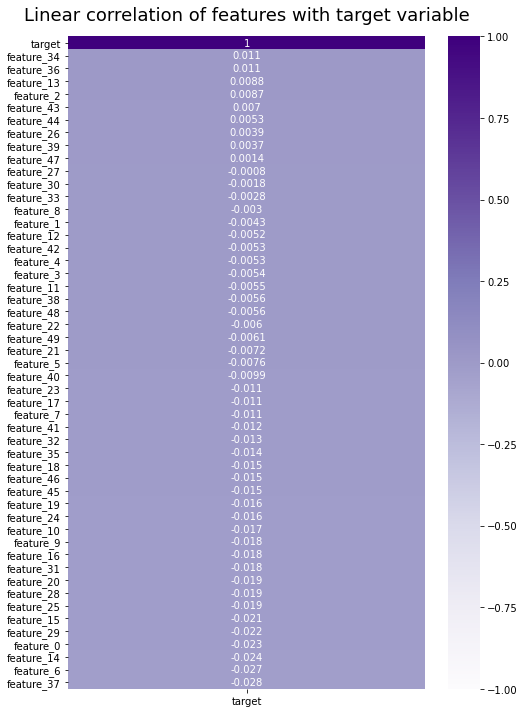

In [43]:
data_train_target_num = data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})

plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_train_target_num.corr()[['target']].sort_values(by='target', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='Purples')

heatmap.set_title('Linear correlation of features with target variable', fontdict={'fontsize': 18}, pad=16);

<h3>Conclusion</h3>

After some visualization and discussion couple of things come up to the light
<ul>
    <li>There aren't any missing values</li>
    <li>Mean and standard deviation is fairly the same for train and test datasets</li>
    <li>Target variable is unbalanced which can be a problem</li>
    <li>Features are left skewed and nearly 60% of every feature is filled with zeros</li>
    <li>Features show weak linear correlation with target variable</li>
</ul>

<h2>Dimensionality Reduction</h2>
There is 50 features in our dataset. It's good opportunity to perform dimensionality reduction but first we gona check if it's necessary to do so.

<h3>Dimensionality reduction using PCA </h3>

In [44]:
pca = PCA().fit(data_train.drop('target', axis=1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = list(range(50)),
    y = np.cumsum(pca.explained_variance_ratio_)
))

fig.update_layout(
    template = 'plotly_dark',
    title_text = 'PCA Performence',
    xaxis_title = 'Number of components',
    yaxis_title = 'Cumulative explained variance'
)

As we can see from scatter plot above variance decreasing quite fast. By the time PCA reduce number of features to the 30 we had lost almost 10% of the variance. It's definitely not worth it to reduce dimensionality of this dataset in order to create prediction model but still we can use dimensionality reduction to visualize our dataset. 

In [45]:
pca_vis = PCA(3)
projected = pca_vis.fit_transform(data_train.drop('target', axis=1))

In [46]:
df_vis = pd.DataFrame(projected, columns=['x', 'y', 'z'])
df_vis['target'] = data_train['target']

In [47]:
fig = px.scatter_3d(df_vis, x='x', y='y', z='z', color='target')

# tight layout
fig.update_layout(
    template='plotly_dark'
)

PCA doesn't work very well but it's doesn't mean that visualization is impossible we gonna use other method to do so

<h3> Dimensionality reduction using umap </h3>

In [48]:
sample_data_train = data_train.sample(1000, random_state=42)
scaled_sample_train = pd.DataFrame(StandardScaler().fit_transform(sample_data_train.drop('target', axis=1)))
scaled_sample_target = sample_data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})['target'].reset_index(drop=True)

In [49]:
reducer_2d = umap.UMAP(random_state=1)
embedding_2d = reducer_2d.fit_transform(scaled_sample_train, scaled_sample_target)

In [50]:
df_test_2d = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df_test_2d['target'] = scaled_sample_target

In [51]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 1]['x'],
    y = df_test_2d[df_test_2d['target'] == 1]['y'],
    mode='markers',
    name='Class_1'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 2]['x'],
    y = df_test_2d[df_test_2d['target'] == 2]['y'],
    mode='markers',
    name='Class_2'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 3]['x'],
    y = df_test_2d[df_test_2d['target'] == 3]['y'],
    mode='markers',
    name='Class_3'
))

fig.add_trace(go.Scatter(
    x = df_test_2d[df_test_2d['target'] == 4]['x'],
    y = df_test_2d[df_test_2d['target'] == 4]['y'],
    mode='markers',
    name='Class_4'
))

fig.update_layout(
    title_text = '2d dataset visualization using UMAP',
    template = 'plotly_dark'
)

In [52]:
reducer_3d = umap.UMAP(random_state=42, n_components=3)
embedding_3d = reducer_3d.fit_transform(scaled_sample_train, scaled_sample_target)

In [53]:
df_test_3d = pd.DataFrame(embedding_3d, columns=['x', 'y', 'z'])
df_test_3d['target'] = scaled_sample_target

In [54]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 1]['x'],
    y = df_test_3d[df_test_3d['target'] == 1]['y'],
    z = df_test_3d[df_test_3d['target'] == 1]['z'],
    mode = 'markers',
    name = 'Class_1',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 2]['x'],
    y = df_test_3d[df_test_3d['target'] == 2]['y'],
    z = df_test_3d[df_test_3d['target'] == 2]['z'],
    mode = 'markers',
    name = 'Class_2',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 3]['x'],
    y = df_test_3d[df_test_3d['target'] == 3]['y'],
    z = df_test_3d[df_test_3d['target'] == 3]['z'],
    mode = 'markers',
    name = 'Class_3',
    marker = dict(
        size=4
    )
))

fig.add_trace(go.Scatter3d(
    x = df_test_3d[df_test_3d['target'] == 4]['x'],
    y = df_test_3d[df_test_3d['target'] == 4]['y'],
    z = df_test_3d[df_test_3d['target'] == 4]['z'],
    mode = 'markers',
    name = 'Class_4',
    marker = dict(
        size=4
    )
))

fig.update_layout(
    title_text = '3d dataset visualization using UMAP',
    template = 'plotly_dark'
)

Now our visualization looks much better we can clearly see clouds of different classes. 

<h2> Prediction model creation </h2>

In [55]:
data_train_num = data_train

X = data_train_num.drop('target', axis=1)
y = data_train_num['target']

<h3> Scalling </h3>

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
# test_scaled = pd.DataFrame(scaler.fit_transform(data_test))

<h3> XGBoost </h3>

In [ ]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [ ]:
xgb_model = XGBClassifier()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = xgb_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        eval_metric = 'mlogloss',
        early_stopping_rounds = 50, 
        verbose = 10
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred1 = test_pred/5

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

<h3> Light Gradient Boost </h3>

In [ ]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [ ]:
lg_model = LGBMClassifier()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = lg_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        eval_metric = 'multi_logloss',
        early_stopping_rounds = 50,
        verbose = 10
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred2 = test_pred/5

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

<h3> Catboost </h3>

In [ ]:
log_pred = np.zeros((len(X), 4))
test_pred = np.zeros((len(data_test), 4))

In [ ]:
cat_model = CatBoostClassifier()

In [ ]:
%%time

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = cat_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        early_stopping_rounds = 50,
        verbose = 10
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred3 = test_pred/10

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

<h3> Catboost  </h3>

In [57]:
cat_model = CatBoostClassifier()

In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (train_index, val_index) in enumerate(skf.split(X, y)):
    print('Fold: ', fold_)
    model = cat_model.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        eval_set = [(X.iloc[train_index], y.iloc[train_index]), (X.iloc[val_index], y.iloc[val_index])],
        early_stopping_rounds = 50,
        verbose = 10
    )

    temp_pred = model.predict_proba(X.iloc[val_index])
    log_pred[val_index] = temp_pred

    print(f'Log Loss: {log_loss(y.iloc[val_index], temp_pred)}')

    temp_test = model.predict_proba(data_test)
    test_pred += temp_test

test_pred += test_pred/5

print(f'Overall Log Loss: {log_loss(y, log_pred)}')

Fold:  0
Learning rate set to 0.117866
0:	learn: 1.3196601	test: 1.3196601	test1: 1.3198079	best: 1.3198079 (0)	total: 33.3ms	remaining: 33.2s
10:	learn: 1.1325624	test: 1.1325624	test1: 1.1335301	best: 1.1335301 (10)	total: 289ms	remaining: 26s
20:	learn: 1.1106186	test: 1.1106186	test1: 1.1132940	best: 1.1132940 (20)	total: 591ms	remaining: 27.6s
30:	learn: 1.1030819	test: 1.1030819	test1: 1.1080388	best: 1.1080388 (30)	total: 926ms	remaining: 29s
40:	learn: 1.0989827	test: 1.0989827	test1: 1.1053242	best: 1.1053242 (40)	total: 1.26s	remaining: 29.4s
50:	learn: 1.0948255	test: 1.0948255	test1: 1.1032628	best: 1.1032628 (50)	total: 1.6s	remaining: 29.8s
60:	learn: 1.0919537	test: 1.0919537	test1: 1.1017969	best: 1.1017969 (60)	total: 1.96s	remaining: 30.2s
70:	learn: 1.0896219	test: 1.0896219	test1: 1.1008486	best: 1.1008486 (70)	total: 2.27s	remaining: 29.8s
80:	learn: 1.0875447	test: 1.0875447	test1: 1.0998566	best: 1.0998566 (80)	total: 2.54s	remaining: 28.9s
90:	learn: 1.0855088	t

In [59]:
df_pred = pd.DataFrame(test_pred)

In [60]:
df_pred

0         1         2         3
0      0.520365  3.855901  0.947403  0.676331
1      0.528126  3.975676  0.949827  0.546371
2      0.512172  3.729169  1.145315  0.613344
3      0.550348  3.279819  1.532590  0.637243
4      0.422650  3.638677  1.170260  0.768414
...         ...       ...       ...       ...
49995  0.532420  4.318019  0.762087  0.387474
49996  0.494349  3.846469  0.813887  0.845295
49997  0.501471  3.156239  1.349464  0.992825
49998  0.478635  3.550503  0.975843  0.995020
49999  0.534412  3.386775  1.207992  0.870820

[50000 rows x 4 columns]

In [ ]:
df_pred1 = pd.DataFrame(test_pred1)
df_pred2 = pd.DataFrame(test_pred2)
df_pred3 = pd.DataFrame(test_pred3)

In [ ]:
data_test1 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test1['Class_1'] = df_pred1[0]
data_test1['Class_2'] = df_pred1[1]
data_test1['Class_3'] = df_pred1[2]
data_test1['Class_4'] = df_pred1[3]

In [ ]:
data_test2 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test2['Class_1'] = df_pred2[0]
data_test2['Class_2'] = df_pred2[1]
data_test2['Class_3'] = df_pred2[2]
data_test2['Class_4'] = df_pred2[3]

In [ ]:
data_test3 = pd.read_csv('data/sample_submission.csv').drop(['Class_1', 'Class_2', 'Class_3', 'Class_4'], axis=1)

data_test3['Class_1'] = df_pred3[0]
data_test3['Class_2'] = df_pred3[1]
data_test3['Class_3'] = df_pred3[2]
data_test3['Class_4'] = df_pred3[3]

In [ ]:
data_test3.to_csv('submission_v4.csv', index=False)